# Quora Similarity Question pair case study
*This case study is about identifying the pair of questions and predict whether they are similar or not. It is a Binary Classification problem.*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('train.csv')

*Doing some basic inspection of the data as follows.*

In [5]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
data.shape

(404290, 6)

- There are 4 relevant input columns namely `qid1`, `qid2`, `question1` and `question2`.
- The output column is `is_duplicate`.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


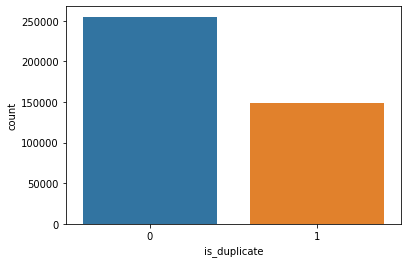

In [7]:
sns.countplot(data['is_duplicate'])
plt.show()

In [8]:
100*data['is_duplicate'].value_counts()/data.shape[0]

0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64

- It can be observed that the category `0` appears more than the category `1`.
- However, it is not a serious imbalance.

*Let's check if there ate duplicate pairs of questions or not.*

In [9]:
pairs = data['qid1'].astype(str) + data['qid2'].astype(str)
duplicates = data.shape[0]-len(np.unique(pairs))
print('The total number of duplicate question pairs are {}'.format(duplicates))

The total number of duplicate question pairs are 0


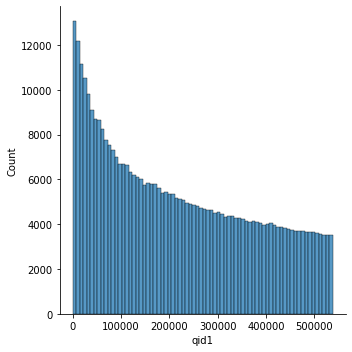

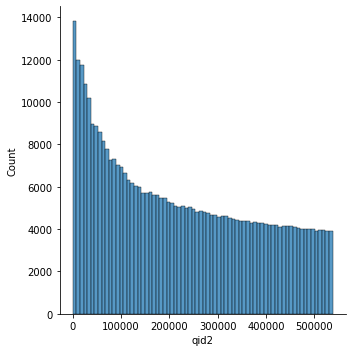

In [10]:
sns.displot(data['qid1'])
sns.displot(data['qid2'])
plt.show()

*Checking for null values as follows*

In [11]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [12]:
data[data.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


- There are 3 null values in total.
- One in `question1` and two in `question2`.

In [13]:
data = data.fillna(' ')

In [14]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [15]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


*Splitting the data into train and test sets*

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data['is_duplicate'], test_size = 0.2, random_state = 0)

In [17]:
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LSTM, concatenate, Embedding, Flatten
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [18]:
tokenizer_q1 = Tokenizer()
tokenizer_q2 = Tokenizer()

tokenizer_q1.fit_on_texts(X_train['question1'])
tokenizer_q2.fit_on_texts(X_train['question2'])

In [19]:
question_1_tk = tokenizer_q1.texts_to_sequences(X_train['question1'])
question_2_tk = tokenizer_q2.texts_to_sequences(X_train['question2'])

In [20]:
question_1_tk_test = tokenizer_q1.texts_to_sequences(X_test['question1'])
question_2_tk_test = tokenizer_q2.texts_to_sequences(X_test['question2'])

*Calculating the length of each question in both the question columns.*

In [21]:
len_q1 = []
for i in question_1_tk:
  len_q1.append(len(i))
len_q2 = []
for i in question_2_tk:
  len_q2.append(len(i))

In [22]:
pd.DataFrame(len_q1).describe(percentiles = [0, 0.25, 0.5, 0.77, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99])

,0
count,323432.000000
mean,11.028751
std,5.498653
min,0.000000
0%,0.000000
25%,7.000000
50%,10.000000
77%,14.000000
90%,18.000000
95%,22.000000


In [23]:
pd.DataFrame(len_q2).describe(percentiles = [0, 0.25, 0.5, 0.77, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99])

,0
count,323432.000000
mean,11.279910
std,6.382974
min,0.000000
0%,0.000000
25%,7.000000
50%,10.000000
77%,14.000000
90%,19.000000
95%,24.000000


- For `question1`, 99% of the sentences have 30 words or less.
- For `question2`, 99% of the sentences have 33 words or less.

*Let's perform the padding as follows*

In [24]:
pad_q1_train = pad_sequences(question_1_tk, maxlen = 33, padding = 'post')
pad_q1_test = pad_sequences(question_1_tk_test, maxlen = 33, padding = 'post')

pad_q2_train = pad_sequences(question_2_tk, maxlen = 33, padding = 'post')
pad_q2_test = pad_sequences(question_2_tk_test, maxlen = 33, padding = 'post')

## Model Building
*Let's try different models for maing the predictions.*

Model 1

In [25]:
input_q1 = Input(shape = (33,))
embedding_1 = Embedding(input_dim = len(tokenizer_q1.word_index.keys()), output_dim = 50)(input_q1)
lstm_layer_1 = LSTM(units = 32, kernel_initializer = 'glorot_normal')(embedding_1)

input_q2 = Input(shape = (33,))
embedding_2 = Embedding(input_dim = len(tokenizer_q2.word_index.keys()), output_dim = 50)(input_q2)
last_layer_2 = LSTM(units = 32, kernel_initializer = 'glorot_normal')(embedding_2)

concatenate_layer = concatenate([input_q1, input_q2])

dense_layer = Dense(64, activation = 'relu')(concatenate_layer)
output_layer = Dense(1, activation = 'sigmoid')(dense_layer)

model_1 = Model(inputs = [input_q1, input_q2], outputs = output_layer)

In [27]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
__________________________________________________________________________________________________


In [35]:
model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')
performance = model_1.fit(x = [pad_q1_train, pad_q2_train], y = y_train, batch_size = 32, epochs = 20, validation_data = ([pad_q1_test, pad_q2_test], y_test))

Epoch 1/20
10108/10108 [==============================] - 18s 2ms/step - loss: 0.6195 - accuracy: 0.6317 - val_loss: 0.6163 - val_accuracy: 0.6306
Epoch 2/20
10108/10108 [==============================] - 17s 2ms/step - loss: 0.6178 - accuracy: 0.6290 - val_loss: 0.6269 - val_accuracy: 0.6306
Epoch 3/20
10108/10108 [==============================] - 17s 2ms/step - loss: 0.6182 - accuracy: 0.6314 - val_loss: 0.6117 - val_accuracy: 0.6306
Epoch 4/20
10108/10108 [==============================] - 17s 2ms/step - loss: 0.6182 - accuracy: 0.6315 - val_loss: 0.6279 - val_accuracy: 0.6306
Epoch 5/20
10108/10108 [==============================] - 17s 2ms/step - loss: 0.6148 - accuracy: 0.6448 - val_loss: 0.6183 - val_accuracy: 0.6306
Epoch 6/20
10108/10108 [==============================] - 17s 2ms/step - loss: 0.6168 - accuracy: 0.6374 - val_loss: 0.6194 - val_accuracy: 0.6306
Epoch 7/20
10108/10108 [==============================] - 17s 2ms/step - loss: 0.6153 - accuracy: 0.6341 - val_loss: 0

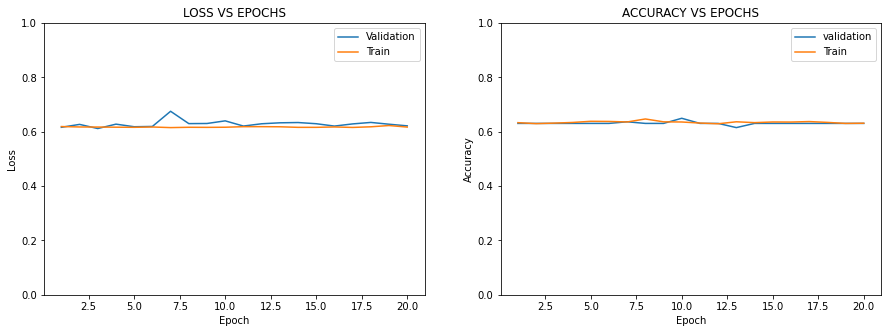

In [36]:
plt.figure(figsize = (15, 5))
plt.subplot(121)
sns.lineplot(x=range(1,21), y=performance.history['val_loss'])
sns.lineplot(x=range(1,21), y=performance.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim((0,1))
plt.title('LOSS VS EPOCHS')
plt.legend(['Validation', 'Train'])
plt.subplot(122)
sns.lineplot(x=range(1,21), y=performance.history['val_accuracy'])
sns.lineplot(x=range(1,21), y=performance.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0,1))
plt.title('ACCURACY VS EPOCHS')
plt.legend(['validation', 'Train'])
plt.show()

Model 2

In [28]:
input_1 = Input(shape = (33,))
input_2 = Input(shape = (33,))
concatenate_layer = concatenate([input_1, input_2])
embedding = Embedding(input_dim = len(tokenizer_q1.word_index.keys())+len(tokenizer_q2.word_index.keys()), output_dim=50)(concatenate_layer)
lstm_1 = LSTM(units = 32)(embedding)
lstm_2 = LSTM(units = 64)(tf.expand_dims(lstm_1, axis=1))
dense_1 = Dense(units = 32, activation = 'relu')(lstm_2)
dense_2 = Dense(units = 1, activation = 'sigmoid')(dense_1)
model_2 = Model(inputs = [input_1, input_2], outputs = dense_2)

In [29]:
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 6,460,119
Trainable params: 6,460,119
Non-trainable params: 0
__________________________________________________________________________________________________


In [31]:
model_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')
performance = model_2.fit(x = [pad_q1_train, pad_q2_train], y = y_train, batch_size = 32, epochs = 10, validation_data = ([pad_q1_test, pad_q2_test], y_test))

Epoch 1/10
10108/10108 [==============================] - 981s 97ms/step - loss: 0.5741 - accuracy: 0.6974 - val_loss: 0.5055 - val_accuracy: 0.7531
Epoch 2/10
10108/10108 [==============================] - 971s 96ms/step - loss: 0.4713 - accuracy: 0.7749 - val_loss: 0.4819 - val_accuracy: 0.7666
Epoch 3/10
10108/10108 [==============================] - 972s 96ms/step - loss: 0.4090 - accuracy: 0.8099 - val_loss: 0.4752 - val_accuracy: 0.7718
Epoch 4/10
10108/10108 [==============================] - 975s 96ms/step - loss: 0.3521 - accuracy: 0.8396 - val_loss: 0.4975 - val_accuracy: 0.7689
Epoch 5/10
10108/10108 [==============================] - 975s 96ms/step - loss: 0.3002 - accuracy: 0.8658 - val_loss: 0.5053 - val_accuracy: 0.7658
Epoch 6/10
10108/10108 [==============================] - 973s 96ms/step - loss: 0.2589 - accuracy: 0.8863 - val_loss: 0.5383 - val_accuracy: 0.7724
Epoch 7/10
10108/10108 [==============================] - 973s 96ms/step - loss: 0.2233 - accuracy: 0.9033

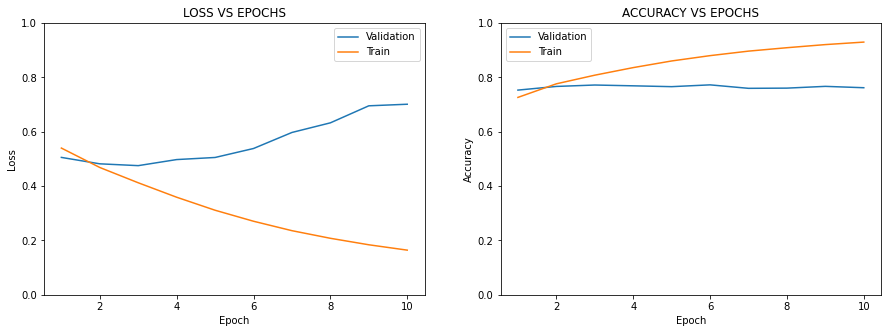

In [34]:
plt.figure(figsize = (15, 5))
plt.subplot(121)
sns.lineplot(x=range(1,11), y=performance.history['val_loss'])
sns.lineplot(x=range(1,11), y=performance.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim((0,1))
plt.title('LOSS VS EPOCHS')
plt.legend(['Validation', 'Train'])
plt.subplot(122)
sns.lineplot(x=range(1,11), y=performance.history['val_accuracy'])
sns.lineplot(x=range(1,11), y=performance.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0,1))
plt.title('ACCURACY VS EPOCHS')
plt.legend(['Validation', 'Train'])
plt.show()

- The performance of the second model is much better than the first model.

Model 3 - *Embeddings using Glove vector representation*

In [32]:
import pickle 
with open('glove_vectors', 'rb') as f:
    glove_vectors = pickle.load(f)
    glove_words =  set(glove_vectors.keys())

In [47]:
vocab_size_1 = len(tokenizer_q1.word_index)
embedding_matrix_1 = np.zeros((vocab_size_1+1, 300))

for word, index in tokenizer_q1.word_index.items():
  embedding_vector = glove_vectors.get(word)
  if embedding_vector is not None:
    embedding_matrix_1[index] = embedding_vector

In [51]:
vocab_size_2 = len(tokenizer_q2.word_index)
embedding_matrix_2 = np.zeros((vocab_size_2+1, 300))

for word, index in tokenizer_q2.word_index.items():
  embedding_vector = glove_vectors.get(word)
  if embedding_vector is not None:
    embedding_matrix_2[index] = embedding_vector

In [53]:
input_1 = Input(shape = (33,))
embedding_1 = Embedding(input_dim = len(tokenizer_q1.word_index.items())+1, output_dim = 300, weights = [embedding_matrix_1])(input_1)
lstm_1 = LSTM(32)(embedding_1)
flatten_1 = Flatten()(lstm_1)

input_2 = Input(shape = (33,))
embedding_2 = Embedding(input_dim = len(tokenizer_q2.word_index.items())+1, output_dim = 300, weights = [embedding_matrix_2])(input_2)
lstm_2 = LSTM(32)(embedding_2)
flatten_2 = Flatten()(lstm_2)

concatenate_layer = concatenate([flatten_1, flatten_2])
dense_1 = Dense(32, activation = 'relu')(concatenate_layer)
dense_2 = Dense(1, activation = 'sigmoid')(dense_1)

model_3 = Model(inputs = [input_1, input_2], outputs = dense_2)

In [54]:
model_3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 38,623,261
Trainable params: 38,623,261
Non-trainable params: 0
__________________________________________________________________________________________________


In [56]:
model_3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')
performance = model_3.fit(x = [pad_q1_train, pad_q2_train], y = y_train, batch_size = 100, epochs = 10, 
                          validation_data = ([pad_q1_test, pad_q2_test], y_test))

Epoch 1/10
3235/3235 [==============================] - 1528s 471ms/step - loss: 0.5432 - accuracy: 0.7228 - val_loss: 0.4761 - val_accuracy: 0.7716
Epoch 2/10
3235/3235 [==============================] - 1515s 468ms/step - loss: 0.4245 - accuracy: 0.8013 - val_loss: 0.4610 - val_accuracy: 0.7831
Epoch 3/10
3235/3235 [==============================] - 1524s 471ms/step - loss: 0.3541 - accuracy: 0.8369 - val_loss: 0.4755 - val_accuracy: 0.7766
Epoch 4/10
3235/3235 [==============================] - 1522s 471ms/step - loss: 0.2924 - accuracy: 0.8669 - val_loss: 0.4906 - val_accuracy: 0.7866
Epoch 5/10
3235/3235 [==============================] - 1518s 469ms/step - loss: 0.2409 - accuracy: 0.8927 - val_loss: 0.5460 - val_accuracy: 0.7729
Epoch 6/10
3235/3235 [==============================] - 1529s 473ms/step - loss: 0.1962 - accuracy: 0.9154 - val_loss: 0.5998 - val_accuracy: 0.7738
Epoch 7/10
3235/3235 [==============================] - 1524s 471ms/step - loss: 0.1602 - accuracy: 0.9321

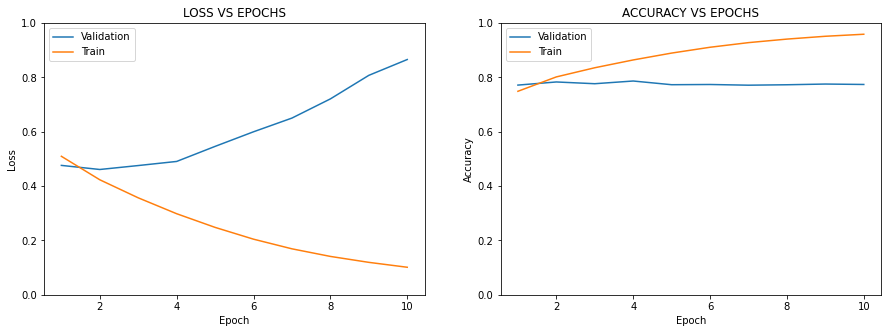

In [57]:
plt.figure(figsize = (15, 5))
plt.subplot(121)
sns.lineplot(x=range(1,11), y=performance.history['val_loss'])
sns.lineplot(x=range(1,11), y=performance.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim((0,1))
plt.title('LOSS VS EPOCHS')
plt.legend(['Validation', 'Train'])
plt.subplot(122)
sns.lineplot(x=range(1,11), y=performance.history['val_accuracy'])
sns.lineplot(x=range(1,11), y=performance.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim((0,1))
plt.title('ACCURACY VS EPOCHS')
plt.legend(['Validation', 'Train'])
plt.show()

- Similar performance to Model 2.

Model 4 - *Combining both the question columns into one.*

In [33]:
questions_combined = data['question1'] + ' ' + data['question2']

In [34]:
new_df = pd.DataFrame(questions_combined, columns = ['questions12'])
new_df['is_duplicate'] = data['is_duplicate']
new_df.head()

,questions12,is_duplicate
0,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,0
2,How can I increase the speed of my internet co...,0
3,Why am I mentally very lonely? How can I solve...,0
4,"Which one dissolve in water quikly sugar, salt...",0


In [35]:
X_train, X_test, y_train, y_test = train_test_split(new_df['questions12'], new_df['is_duplicate'], test_size = 0.2, random_state = 0)

In [36]:
tokenizer_qs = Tokenizer()
tokenizer_qs.fit_on_texts(X_train)

In [37]:
questions_tk_train = tokenizer_qs.texts_to_sequences(X_train)
questions_tk_test = tokenizer_qs.texts_to_sequences(X_test)

In [38]:
len_tr = [len(i) for i in questions_tk_train]
len_ts = [len(i) for i in questions_tk_test]

In [39]:
pd.DataFrame(len_tr).describe(percentiles = [0, 0.25, 0.50, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99])

,0
count,323432.000000
mean,22.308661
std,10.207573
min,2.000000
0%,2.000000
25%,16.000000
50%,20.000000
75%,26.000000
90%,35.000000
95%,42.000000


In [40]:
pd.DataFrame(len_ts).describe(percentiles = [0, 0.25, 0.50, 0.75, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99])

,0
count,80858.000000
mean,22.192956
std,10.141263
min,4.000000
0%,4.000000
25%,16.000000
50%,20.000000
75%,26.000000
90%,35.000000
95%,42.000000


- 99% of sentences have a length of 57 or less.

In [41]:
padded_questions_tr = pad_sequences(questions_tk_train, maxlen = 57, padding = 'post')
padded_questions_ts = pad_sequences(questions_tk_test, maxlen = 57, padding = 'post')

In [42]:
vocab_size_12 = len(tokenizer_qs.word_index)
embedding_matrix_12 = np.zeros((vocab_size_12+1, 300))

for word, index in tokenizer_qs.word_index.items():
  embedding_vector = glove_vectors.get(word)
  if embedding_vector is not None:
    embedding_matrix_12[index] = embedding_vector

In [48]:
input_layer = Input(shape = (57,))
embedding_layer = Embedding(input_dim = vocab_size_12+1, output_dim = 300, weights = [embedding_matrix_12])(input_layer)
lstm_1 = LSTM(100, return_sequences = True)(embedding_layer)
flatten_layer = Flatten()(lstm_1)
dense_1 = Dense(32, activation = 'relu')(flatten_layer)
dense_2 = Dense(16, activation = 'relu')(dense_1)
output_layer = Dense(1, activation = 'sigmoid')(dense_2)

model_4 = Model(inputs = [input_layer], outputs = [output_layer])

In [49]:
model_4.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 26,222,277
Trainable params: 26,222,277
Non-trainable params: 0
_________________________________________________________________


In [50]:
model_4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = 'accuracy')
performance = model_4.fit(x = padded_questions_tr, y = y_train, batch_size = 100, epochs = 10, 
                          validation_data = (padded_questions_ts, y_test))

Epoch 1/10
3235/3235 [==============================] - 1344s 412ms/step - loss: 0.5339 - accuracy: 0.7295 - val_loss: 0.4643 - val_accuracy: 0.7776
Epoch 2/10
3235/3235 [==============================] - 1320s 408ms/step - loss: 0.4023 - accuracy: 0.8115 - val_loss: 0.4460 - val_accuracy: 0.7892
Epoch 3/10
3235/3235 [==============================] - 1314s 406ms/step - loss: 0.2977 - accuracy: 0.8652 - val_loss: 0.4717 - val_accuracy: 0.7937
Epoch 4/10
3235/3235 [==============================] - 1301s 402ms/step - loss: 0.2103 - accuracy: 0.9092 - val_loss: 0.5497 - val_accuracy: 0.7925
Epoch 5/10
3235/3235 [==============================] - 1301s 402ms/step - loss: 0.1462 - accuracy: 0.9391 - val_loss: 0.6564 - val_accuracy: 0.7910
Epoch 6/10
3235/3235 [==============================] - 1284s 397ms/step - loss: 0.1007 - accuracy: 0.9593 - val_loss: 0.8391 - val_accuracy: 0.7897
Epoch 7/10
3235/3235 [==============================] - 1279s 395ms/step - loss: 0.0710 - accuracy: 0.9723

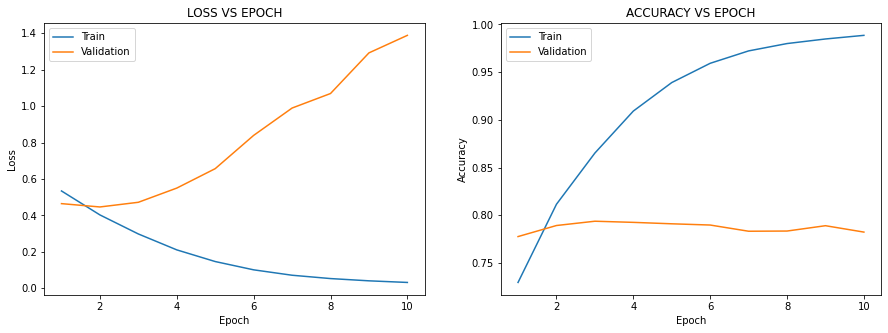

In [9]:
loss = [0.5339, 0.4023, 0.2977, 0.2103, 0.1462, 0.1007, 0.0710, 0.0527, 0.0403, 0.0314]
accuracy = [0.7295, 0.8115, 0.8652, 0.9092, 0.9391, 0.9593, 0.9723, 0.9800, 0.9848, 0.9886]
val_loss = [0.4643, 0.4460, 0.4717, 0.5497, 0.6564, 0.8391, 0.9893, 1.0691, 1.2923, 1.3886]
val_accuracy = [0.7776, 0.7892, 0.7937, 0.7925, 0.7910, 0.7897, 0.7832, 0.7834, 0.7890, 0.7823]

plt.figure(figsize = (15, 5))
plt.subplot(121)
sns.lineplot(x = range(1, 11), y = loss)
sns.lineplot(x = range(1, 11), y = val_loss)
plt.legend(['Train', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LOSS VS EPOCH')
plt.subplot(122)
sns.lineplot(x = range(1, 11), y = accuracy)
sns.lineplot(x = range(1, 11), y = val_accuracy)
plt.legend(['Train', 'Validation'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ACCURACY VS EPOCH')
plt.show()

## CONCLUSION
- Using glove vectors as word embeddings clearly boosted the performance in comparison to Model 1. 
- However, same is not the case when compared with Model 2 which didn't have the glove vector representation.
- Model 2 performed almost equally with Model 3 and Model 4.